# Introduction: Home Credit Default Risk Competition

This notebook is intended for those who are new to machine learning competitions or want a gentle introduction to the problem. I purposely avoid jumping into complicated models or joining together lots of data in order to show the basics of how to get started in machine learning! Any comments or suggestions are much appreciated.

In this notebook, we will take an initial look at the Home Credit default risk machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. This is a standard supervised classification task:

* __Supervised__: The labels are included in the training data and the goal is to train a model to learn to predict the labels from the features
* __Classification__: The label is a binary variable, 0 (will repay loan on time), 1 (will have difficulty repaying loan)


# Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service dedicated to provided lines of credit (loans) to the unbanked population. Predicting whether or not a client will repay a loan or have difficulty is a critical business need, and Home Credit is hosting this competition on Kaggle to see what sort of models the machine learning community can develop to help them in this task. 

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid. 
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length. 
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`. 
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment. 

This diagram shows how all of the data is related:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

Moreover, we are provided with the definitions of all the columns (in `HomeCredit_columns_description.csv`) and an example of the expected submission file. 

In this notebook, we will stick to using only the main application training and testing data. Although if we want to have any hope of seriously competing, we need to use all the data, for now we will stick to one file which should be more manageable. This will let us establish a baseline that we can then improve upon. With these projects, it's best to build up an understanding of the problem a little at a time rather than diving all the way in and getting completely lost! 

## Metric: ROC AUC

Once we have a grasp of the data (reading through the [column descriptions](https://www.kaggle.com/c/home-credit-default-risk/data) helps immensely), we need to understand the metric by which our submission is judged. In this case, it is a common classification metric known as the [Receiver Operating Characteristic Area Under the Curve (ROC AUC, also sometimes called AUROC)](https://stats.stackexchange.com/questions/132777/what-does-auc-stand-for-and-what-is-it).

The ROC AUC may sound intimidating, but it is relatively straightforward once you can get your head around the two individual concepts. The [Reciever Operating Characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) graphs the true positive rate versus the false positive rate:

![image](http://www.statisticshowto.com/wp-content/uploads/2016/08/ROC-curve.png)

A single line on the graph indicates the curve for a single model, and movement along a line indicates changing the threshold used for classifying a positive instance. The threshold starts at 0 in the upper right to and goes to 1 in the lower left. A curve that is to the left and above another curve indicates a better model. For example, the blue model is better than the red model, which is better than the black diagonal line which indicates a naive random guessing model. 

The [Area Under the Curve (AUC)](http://gim.unmc.edu/dxtests/roc3.htm) explains itself by its name! It is simply the area under the ROC curve. (This is the integral of the curve.) This metric is between 0 and 1 with a better model scoring higher. A model that simply guesses at random will have an ROC AUC of 0.5.

When we measure a classifier according to the ROC AUC, we do not generation 0 or 1 predictions, but rather a probability between 0 and 1. This may be confusing because we usually like to think in terms of accuracy, but when we get into problems with inbalanced classes (we will see this is the case), accuracy is not the best metric. For example, if I wanted to build a model that could detect terrorists with 99.9999% accuracy, I would simply make a model that predicted every single person was not a terrorist. Clearly, this would not be effective (the recall would be zero) and we use more advanced metrics such as ROC AUC or the [F1 score](https://en.wikipedia.org/wiki/F1_score) to more accurately reflect the performance of a classifier. A model with a high ROC AUC will also have a high accuracy, but the [ROC AUC is a better representation of model performance.](https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy)

Not that we know the background of the data we are using and the metric to maximize, let's get into exploring the data. In this notebook, as mentioned previously, we will stick to the main data sources and simple models which we can build upon in future work. 

__Follow-up Notebooks__

For those looking to keep working on this problem, I have a series of follow-up notebooks:

* [Manual Feature Engineering Part One](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering)
* [Manual Feature Engineering Part Two](https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2)
* [Introduction to Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/automated-feature-engineering-basics)
* [Advanced Automated Feature Engineering](https://www.kaggle.com/willkoehrsen/tuning-automated-feature-engineering-exploratory)
* [Feature Selection](https://www.kaggle.com/willkoehrsen/introduction-to-feature-selection)
* [Intro to Model Tuning: Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
* [Automated Model Tuning](https://www.kaggle.com/willkoehrsen/automated-model-tuning)
* [Model Tuning Results](https://www.kaggle.com/willkoehrsen/model-tuning-results-random-vs-bayesian-opt/notebook)


I'll add more notebooks as I finish them! Thanks for all the comments! 

## Imports

We are using a typical data science stack: `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import sklearn.metrics as metrics
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV


## Read in Data 

First, we can list all the available data files. There are a total of 9 files: 1 main file for training (with target) 1 main file for testing (without the target), 1 example submission file, and 6 other files containing additional information about each loan. 

In [2]:
# List files available
print(os.listdir("../DS_P7-main/data/"))

['installments_payments.csv', 'application_test.csv', 'credit_card_balance.csv', 'bureau.csv', 'previous_application.csv', 'POS_CASH_balance.csv', 'sample_submission.csv', 'HomeCredit_columns_description.csv', 'bureau_balance.csv', 'application_train.csv']


In [3]:
# Training data
app_train = pd.read_csv('../DS_P7-main/data/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
app_train,app_test  = train_test_split(app_train,test_size=0.3,
                                                                random_state=1,stratify=app_train['TARGET'])

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [8]:
# Testing data features
print('Training data shape: ', app_train.shape)

print('Testing data shape: ', app_test.shape)
app_test.head()

Training data shape:  (215257, 122)
Testing data shape:  (92254, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
159904,285360,0,Cash loans,F,N,Y,0,198000.0,513531.0,24835.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
161941,287735,0,Cash loans,F,N,N,0,85500.0,247275.0,17586.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
77153,189459,0,Cash loans,M,N,Y,0,99000.0,239850.0,23494.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
85929,199711,0,Cash loans,F,Y,Y,0,382500.0,945000.0,40167.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
204245,336787,0,Cash loans,F,N,Y,1,157500.0,601470.0,30838.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


The test set is considerably smaller and lacks a `TARGET` column. 

# Exploratory Data Analysis

Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [9]:
app_train['TARGET'].value_counts()
#0  le loan a été payé ds les temps
#1 le client a eu des pb pour payer

0    197880
1     17377
Name: TARGET, dtype: int64

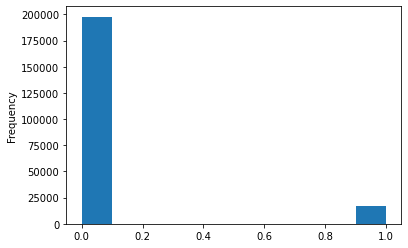

In [10]:
app_train['TARGET'].astype(int).plot.hist();

$\color{red}{\text{Ici on va travailler avec une pb de imbalance class il existe différentes méthodes et tout dépend du modèle ausi non ? }}$


From this information, we see this is an [_imbalanced class problem_](http://www.chioka.in/class-imbalance-problem/). There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can [weight the classes](http://xgboost.readthedocs.io/en/latest/parameter.html) by their representation in the data to reflect this imbalance. 

## Examine Missing Values

Next we can look at the number and percentage of missing values in each column. 

In [11]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [12]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,150612,70.0
COMMONAREA_AVG,150612,70.0
COMMONAREA_MODE,150612,70.0
NONLIVINGAPARTMENTS_MEDI,149644,69.5
NONLIVINGAPARTMENTS_MODE,149644,69.5
NONLIVINGAPARTMENTS_AVG,149644,69.5
FONDKAPREMONT_MODE,147370,68.5
LIVINGAPARTMENTS_MODE,147326,68.4
LIVINGAPARTMENTS_MEDI,147326,68.4
LIVINGAPARTMENTS_AVG,147326,68.4


When it comes time to build our machine learning models, we will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can [handle missing values with no need for imputation](https://stats.stackexchange.com/questions/235489/xgboost-can-handle-missing-data-in-the-forecasting-phase). Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

$\color{red}{\text{Lightgbm lui ignore les Nan durant le split en fait ? }}$



## Column Types

Let's look at the number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) . 

In [13]:
# Number of each type of column
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Let's now look at the number of unique entries in each of the `object` (categorical) columns.

In [14]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Most of the categorical variables have a relatively small number of unique entries. We will need to find a way to deal with these categorical variables! 

## Encoding Categorical Variables

Before we go any further, we need to deal with pesky categorical variables.  A machine learning model unfortunately cannot deal with categorical variables (except for some models such as [LightGBM](http://lightgbm.readthedocs.io/en/latest/Features.html)). Therefore, we have to find a way to encode (represent) these variables as numbers before handing them off to the model. There are two main ways to carry out this process:

* Label encoding: assign each unique category in a categorical variable with an integer. No new columns are created. An example is shown below

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: create a new column for each unique category in a categorical variable. Each observation recieves a 1 in the column for its corresponding category and a 0 in all other new columns. 

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)

The problem with label encoding is that it gives the categories an arbitrary ordering. The value assigned to each of the categories is random and does not reflect any inherent aspect of the category. In the example above, programmer recieves a 4 and data scientist a 1, but if we did the same process again, the labels could be reversed or completely different. The actual assignment of the integers is arbitrary. Therefore, when we perform label encoding, the model might use the relative value of the feature (for example programmer = 4 and data scientist = 1) to assign weights which is not what we want. If we only have two unique values for a categorical variable (such as Male/Female), then label encoding is fine, but for more than 2 unique categories, one-hot encoding is the safe option.

There is some debate about the relative merits of these approaches, and some models can deal with label encoded categorical variables with no issues. [Here is a good Stack Overflow discussion](https://datascience.stackexchange.com/questions/9443/when-to-use-one-hot-encoding-vs-labelencoder-vs-dictvectorizor). I think (and this is just a personal opinion) for categorical variables with many classes, one-hot encoding is the safest approach because it does not impose arbitrary values to categories. The only downside to one-hot encoding is that the number of features (dimensions of the data) can explode with categorical variables with many categories. To deal with this, we can perform one-hot encoding followed by [PCA](http://www.cs.otago.ac.nz/cosc453/student_tutorials/principal_components.pdf) or other [dimensionality reduction methods](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) to reduce the number of dimensions (while still trying to preserve information). 

In this notebook, we will use Label Encoding for any categorical variables with only 2 categories and One-Hot Encoding for any categorical variables with more than 2 categories. This process may need to change as we get further into the project, but for now, we will see where this gets us. (We will also not use any dimensionality reduction in this notebook but will explore in future iterations).

### Label Encoding and One-Hot Encoding

Let's implement the policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding. 

For label encoding, we use the Scikit-Learn `LabelEncoder` and for one-hot encoding, the pandas `get_dummies(df)` function.

In [15]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [16]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (215257, 122)
Testing Features shape:  (92254, 122)


$\color{red}{\text{Je connaissais pas pd.get_dummies donc à quoi sert le ohe que j utilise ds les autres projets ?  }}$

In [17]:
# one-hot encoding of categorical variables
#Je connaissais pas pd.get_dummies 

#On passe tout d'un coup comme cela ce concentre que sur des colonnes objects et on a déjà géré les autres avant avec le label encoding
#Il ne reste plus que les autres pour le ohe 
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (215257, 243)
Testing Features shape:  (92254, 241)


In [18]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'HOUSETYPE_MODE_terraced house', 'WALLSMATERIAL_MODE_Block',
       'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic',
       'WALLSMATERIAL_MODE_Others', 'WALLSMATERIAL_MODE_Panel',
       'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
       'EMERGENCYSTATE_MODE_No', 'EMERGENCYSTATE_MODE_Yes'],
      dtype='object', length=243)

$\color{red}{\text{je comprends pas ici le principe ou le but du aligning  }}$

### Aligning Training and Testing Data

There need to be the same features (columns) in both the training and testing data. One-hot encoding has created more columns in the training data because there were some categorical variables with categories not represented in the testing data. To remove the columns in the training data that are not in the testing data, we need to `align` the dataframes. First we extract the target column from the training data (because this is not in the testing data but we need to keep this information). When we do the align, we must make sure to set `axis = 1` to align the dataframes based on the columns and not on the rows!

In [19]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (215257, 241)
Testing Features shape:  (92254, 241)


The training and testing datasets now have the same features which is required for machine learning. The number of features has grown significantly due to one-hot encoding. At some point we probably will want to try [dimensionality reduction (removing features that are not relevant)](https://en.wikipedia.org/wiki/Dimensionality_reduction) to reduce the size of the datasets.


$\color{red}{\text{#Pk utiliser une méthode de réduction ? il n'y a pas temps de données que ca ? }}$
$\color{red}{\text{#et pk il n a pas regardé la représentation de chaque classe pour éviter le pb des sparses matrix et de dimensions }}$

## Back to Exploratory Data Analysis

### Anomalies

One problem we always want to be on the lookout for when doing EDA is anomalies within the data. These may be due to mis-typed numbers, errors in measuring equipment, or they could be valid but extreme measurements. One way to support anomalies quantitatively is by looking at the statistics of a column using the `describe` method. The numbers in the `DAYS_BIRTH` column are negative because they are recorded relative to the current loan application. To see these stats in years, we can mutliple by -1 and divide by the number of days in a year:


$\color{red}{\text{Les chiffres de la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours.
Pour voir ces statistiques en années, nous pouvons les multiplier par -1 et les diviser par le nombre de jours dans une année :}}$

$\color{blue}{\text{DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!).}}$


In [20]:
app_train['DAYS_BIRTH'].head(n=10)

66405     -9819
39888    -14631
118218   -12705
9571      -8185
25941    -15599
1923     -19147
1414     -13346
169843   -13648
134890   -10952
36389    -19531
Name: DAYS_BIRTH, dtype: int64

In [21]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    215257.000000
mean         43.962228
std          11.950104
min          20.517808
25%          34.043836
50%          43.161644
75%          53.950685
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment? 

In [22]:
app_train['DAYS_EMPLOYED'].describe()

count    215257.000000
mean      63798.582676
std      141262.138489
min      -17546.000000
25%       -2757.000000
50%       -1214.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

That doesn't look right! The maximum value (besides being positive) is about 1000 years! 

$\color{red}{\text{A regarder aussi DAYS_EMPLOYED}}$

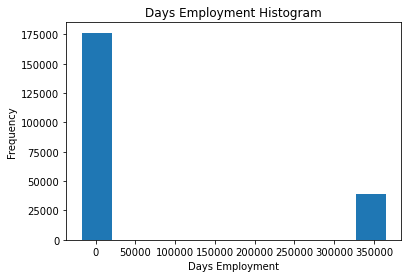

In [23]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Just out of curiousity, let's subset the anomalous clients and see if they tend to have higher or low rates of default than the rest of the clients.

In [24]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.64% of loans
The anomalies default on 5.47% of loans
There are 38752 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default. 

Handling the anomalies depends on the exact situation, with no set rules. One of the safest approaches is just to set the anomalies to a missing value and then have them filled in (using Imputation) before machine learning. In this case, since all the anomalies have the exact same value, we want to fill them in with the same value in case all of these loans share something in common. The anomalous values seem to have some importance, so we want to tell the machine learning model if we did in fact fill in these values. As a solution, we will fill in the anomalous values with not a number (`np.nan`) and then create a new boolean column indicating whether or not the value was anomalous.



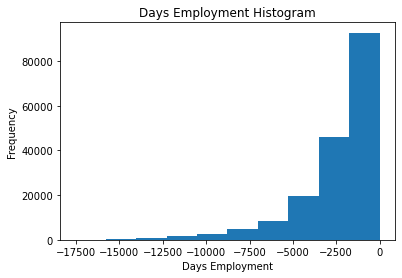

In [25]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

The distribution looks to be much more in line with what we would expect, and we also have created a new column to tell the model that these values were originally anomalous (becuase we will have to fill in the nans with some value, probably the median of the column). The other columns with `DAYS` in the dataframe look to be about what we expect with no obvious outliers. 

As an extremely important note, anything we do to the training data we also have to do to the testing data. Let's make sure to create the new column and fill in the existing column with `np.nan` in the testing data.

In [26]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 16622 anomalies in the test data out of 92254 entries


### Correlations

Now that we have dealt with the categorical variables and the outliers, let's continue with the EDA. One way to try and understand the data is by looking for correlations between the features and the target. We can calculate the Pearson correlation coefficient between every variable and the target using the `.corr` dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some [general interpretations of the absolute value of the correlation coefficent](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf) are:


* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


$\color{red}{\text{Je comprends et je comprends pas en même temps, il regarde la correlation mais n obtient que un feature avec un score ou est le 2ème feature ? }}$

In [27]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.041363
REG_CITY_NOT_LIVE_CITY                               0.043063
FLAG_EMP_PHONE                                       0.044739
FLAG_DOCUMENT_3                                      0.044830
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049783
REG_CITY_NOT_WORK_CITY                               0.049953
DAYS_ID_PUBLISH                                      0.051301
CODE_GENDER_M                                        0.053125
DAYS_LAST_PHONE_CHANGE                               0.054552
NAME_INCOME_TYPE_Working                             0.058103
REGION_RATING_CLIENT                                 0.060669
REGION_RATING_CLIENT_W_CITY                          0.062197
DAYS_EMPLOYED                                        0.073130
DAYS_BIRTH                                           0.075754
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Let's take a look at some of more significant correlations: the `DAYS_BIRTH` is the most positive correlation. (except for `TARGET` because the correlation of a variable with itself is always 1!) Looking at the documentation, `DAYS_BIRTH` is the age in days of the client at the time of the loan in negative days (for whatever reason!). The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). That's a little confusing, so we will take the absolute value of the feature and then the correlation will be negative.

### Effect of Age on Repayment

$\color{red}{\text{A ressayer de comprendre }}$

In [28]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07575364881734026

As the client gets older, there is a negative linear relationship with the target meaning that as clients get older, they tend to repay their loans on time more often. 

Let's start looking at this variable. First, we can make a histogram of the age. We will put the x axis in years to make the plot a little more understandable.

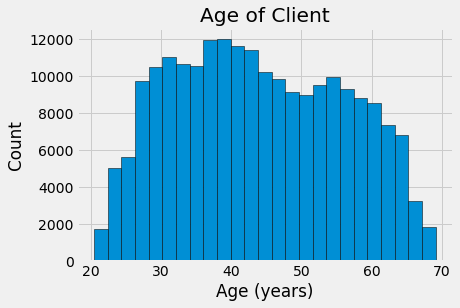

In [29]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a [kernel density estimation plot](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE) colored by the value of the target. A [kernel density estimate plot shows the distribution of a single variable](https://chemicalstatistician.wordpress.com/2013/06/09/exploratory-data-analysis-kernel-density-estimation-in-r-on-ozone-pollution-data-in-new-york-and-ozonopolis/) and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn `kdeplot` for this graph.

The target == 1 curve skews towards the younger end of the range. Although this is not a significant correlation (-0.07 correlation coefficient), this variable is likely going to be useful in a machine learning model because it does affect the target. Let's look at this relationship in another way: average failure to repay loans by age bracket. 

To make this graph, first we `cut` the age category into bins of 5 years each. Then, for each bin, we calculate the average value of the target, which tells us the ratio of loans that were not repaid in each age category.

In [30]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
66405,0,9819,26.901370,"(25.0, 30.0]"
39888,0,14631,40.084932,"(40.0, 45.0]"
118218,0,12705,34.808219,"(30.0, 35.0]"
9571,1,8185,22.424658,"(20.0, 25.0]"
25941,0,15599,42.736986,"(40.0, 45.0]"
1923,1,19147,52.457534,"(50.0, 55.0]"
1414,0,13346,36.564384,"(35.0, 40.0]"
169843,0,13648,37.391781,"(35.0, 40.0]"
134890,0,10952,30.005479,"(30.0, 35.0]"
36389,0,19531,53.509589,"(50.0, 55.0]"


In [31]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.120743,8533.833889,23.380367
"(25.0, 30.0]",0.110330,10155.935408,27.824481
"(30.0, 35.0]",0.101881,11857.074855,32.485137
"(35.0, 40.0]",0.090918,13706.809345,37.552902
"(40.0, 45.0]",0.078009,15495.836669,42.454347
"(45.0, 50.0]",0.073946,17322.503850,47.458915
"(50.0, 55.0]",0.068615,19196.294012,52.592586
"(55.0, 60.0]",0.055133,20982.821323,57.487182
"(60.0, 65.0]",0.052968,22778.412144,62.406609


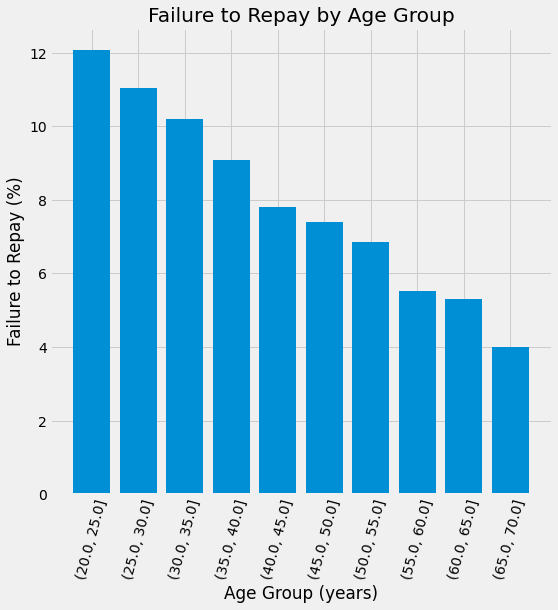

In [32]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and beolow 5% for the oldest age group.

This is information that could be directly used by the bank: because younger clients are less likely to repay the loan, maybe they should be provided with more guidance or financial planning tips. This does not mean the bank should discriminate against younger clients, but it would be smart to take precautionary measures to help younger clients pay on time.

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data. 

Let's take a look at these variables.

First, we can show the correlations of the `EXT_SOURCE` features with the target and with each other.

In [33]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.152178,-0.160270,-0.178625,-0.075754
EXT_SOURCE_1,-0.152178,1.000000,0.212129,0.184145,0.602550
EXT_SOURCE_2,-0.160270,0.212129,1.000000,0.108016,0.089610
EXT_SOURCE_3,-0.178625,0.184145,0.108016,1.000000,0.202069
DAYS_BIRTH,-0.075754,0.602550,0.089610,0.202069,1.000000


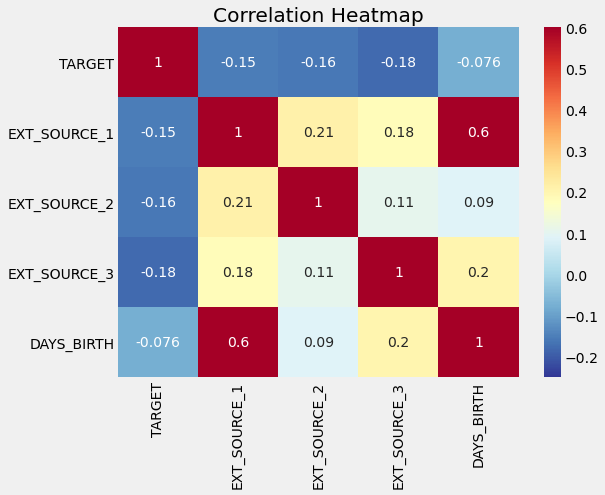

In [34]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

Next we can look at the distribution of each of these features colored by the value of the target. This will let us visualize the effect of this variable on the target.

`EXT_SOURCE_3` displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all [considered very weak](http://www.statstutor.ac.uk/resources/uploaded/pearsons.pdf), but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

# Imputer à changer 

In [35]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'DAYS_EMPLOYED_ANOM'],
      dtype='object', length=242)

In [36]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

app_train_target = app_train['TARGET']

app_train_features = app_train.columns
# Need to impute missing values
app_train = imputer.fit_transform(app_train)
#app_train = imputer.transform(poly_features_test)
app_train=pd.DataFrame(app_train,columns=app_train_features)

In [37]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')


app_test_features = app_test.columns
# Need to impute missing values
app_test = imputer.fit_transform(app_test)
#app_test = imputer.transform(poly_features_test)
app_test=pd.DataFrame(app_test,columns=app_test_features)

In [38]:
app_train.shape

(215257, 242)

# Feature Engineering

Kaggle competitions are won by feature engineering: those win are those who can create the most useful features out of the data. (This is true for the most part as the winning models, at least for structured data, all tend to be variants on [gradient boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)). This represents one of the patterns in machine learning: feature engineering has a greater return on investment than model building and hyperparameter tuning. [This is a great article on the subject)](https://www.featurelabs.com/blog/secret-to-data-science-success/). As Andrew Ng is fond of saying: "applied machine learning is basically feature engineering." 

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some [automated tools](https://docs.featuretools.com/getting_started/install.html) to help us out).

Feature engineering refers to a geneal process and can involve both feature construction: adding new features from the existing data, and feature selection: choosing only the most important features or other methods of dimensionality reduction. There are many techniques we can use to both create features and select features.

We will do a lot of feature engineering when we start using the other data sources, but in this notebook we will try only two simple feature construction methods: 

* Polynomial features
* Domain knowledge features


## Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by [this script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) by Aguiar:

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

Again, thanks to Aguiar and [his great script](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) for exploring these features.



$\color{purple}{\text{AMT is imposed if the tentative minimum tax exceeds the regular tax.[40] Tentative minimum tax is the AMT rate of tax times alternative minimum taxable income (AMTI) less the AMT foreign tax credit. Regular tax is the regular income tax reduced only by the foreign and possessions tax credits.[19] In any year in which regular tax exceeds tentative minimum tax, a credit (AMT Credit) is allowed against regular tax to the extent the taxpayer has paid AMT in any prior year. This credit may not reduce regular tax below the tentative minimum tax.}}$


In [39]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [40]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [42]:
app_train_domain.to_csv('app_train_domain.csv',index=False)
app_test_domain.to_csv('app_test_domain.csv',index=False)

In [41]:
X=app_train_domain.drop('TARGET', 1)

y=app_train_domain['TARGET']
print('Avant : ')
print('app_train_domain :',app_train_domain.shape)
print('app_test_domain :',app_test_domain.shape)
print('X :',X.shape)
print('y :',y.shape)



Avant : 
app_train_domain : (215257, 246)
app_test_domain : (92254, 246)
X : (215257, 245)
y : (215257,)


In [38]:
SEED=1
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.3,
                                                                random_state=SEED,stratify=y)

#Debut 
#split sur train.csv
#train1 et test1
#preprocessing ...
#split train1
#trainbis, valbis, test1

In [44]:
print('Après : ')
print('X_train :',X_train.shape)
print('X_val :',X_val.shape)
print('app_test_domain :',app_test_domain.shape)


Après : 
X_train : (215257, 244)
X_val : (92254, 244)
app_test_domain : (48744, 244)


# Undersampling 

!python -m pip install -U imbalanced-learn

In [45]:
import imblearn 
print(imblearn.__version__)
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler

0.7.0


In [46]:
undersample=RandomUnderSampler(sampling_strategy='majority')

In [47]:
X_under,y_under=undersample.fit_resample(X_train, y_train)
print(Counter(y_under))

Counter({0.0: 17377, 1.0: 17377})


# Oversampling 

In [48]:
from imblearn.over_sampling import SMOTE

# summarize class distribution
counter = Counter(y_train)
print(counter)


Counter({0.0: 197880, 1.0: 17377})


In [49]:
197880/17377

11.38746619094205

In [50]:
17377*1.11

19288.47

In [51]:
#Fallait il mettre 1 ? 

In [52]:
over = SMOTE(sampling_strategy=1, k_neighbors=5)
X_over,y_over=over.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({0.0: 197880, 1.0: 197880})


class_weight={0:1,1:2}

# A Faire 
- Undersampling 
- Oversampling : SMOTE (voisinage) 
- Class weight 
- Métrique 

In [53]:
comp_model = pd.DataFrame( columns=['Model','Train_score',
                                    'Test_score'])

In [54]:
import re
from sklearn.metrics import accuracy_score
from sklearn import metrics

def lgb(df_x_train,df_y_train,df_x_val,df_y_val,name_tech,df_save):
    
    lgb=LGBMClassifier()
    lgb_param_grid = {
            'learning_rate': [0.01,0.1,0.5,0.9],
            'n_estimators': [300,500,700],
            'subsample': [0.3, 0.4, 0.6]
            }



    grid_lgb = GridSearchCV(estimator=lgb,
                                    param_grid=lgb_param_grid, cv=3,
                                    scoring='roc_auc')
    
    df_x_train = df_x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    grid_lgb.fit(df_x_train, df_y_train)
    accu_train_lgb=grid_lgb.best_score_

    best_hyperparams = grid_lgb.best_params_

    best_model_lgb = grid_lgb.best_estimator_
    y_pred = best_model_lgb.predict(df_x_val)
    accu_test_lgb=metrics.roc_auc_score(df_y_val, y_pred)
    
    data = [{'Model': name_tech,
                 'Train_score':accu_train_lgb,
                 'Test_score':accu_test_lgb,
                }]
    
    
    
    
    df_save=df_save.append(data,ignore_index=True,sort=False)
    return df_save 

In [55]:
name='undersampling'
comp_model=lgb(df_x_train=X_under,
               df_y_train=y_under,
               df_x_val=X_val,
               df_y_val=y_val,
               name_tech=name,
               df_save=comp_model)

In [56]:
comp_model

,Model,Train_score,Test_score
0,undersampling,0.754758,0.69382


In [57]:
import re
from sklearn.metrics import accuracy_score

def lgb_balance(df_x_train,df_y_train,df_x_val,df_y_val,name_tech,df_save):
    
    lgb=LGBMClassifier(class_weight='balanced')
    lgb_param_grid = {
            'learning_rate': [0.01,0.1,0.5,0.9],
            'n_estimators': [300,500,700],
            'subsample': [0.3, 0.4, 0.6]
            }



    grid_lgb = GridSearchCV(estimator=lgb,
                                    param_grid=lgb_param_grid, cv=5,
                                    scoring='roc_auc')
    
    df_x_train = df_x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    grid_lgb.fit(df_x_train, df_y_train)
    accu_train_lgb=grid_lgb.best_score_

    best_hyperparams = grid_lgb.best_params_

    best_model_lgb = grid_lgb.best_estimator_
    y_pred = best_model_lgb.predict(df_x_val)
    accu_test_lgb=metrics.roc_auc_score(df_y_val, y_pred)
    data = [{'Model': name_tech,
                 'Train_score':accu_train_lgb,
                 'Test_score':accu_test_lgb,
                }]
    
    
    
    
    df_save=df_save.append(data,ignore_index=True,sort=False)
    return df_save

In [58]:
name='balanced'
comp_model=lgb_balance(df_x_train=X_under,
               df_y_train=y_under,
               df_x_val=X_val,
               df_y_val=y_val,
               name_tech=name,
               df_save=comp_model)

In [59]:
comp_model

,Model,Train_score,Test_score
0,undersampling,0.754758,0.69382
1,balanced,0.756565,0.69382


!python -m pip install -U hyperopt

In [82]:
from sklearn.metrics import confusion_matrix


def performance_measure(y_actual, y_pred,data,name_col):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    list_resultat=[]
    #Etape 1 : identifier qui est qui ? 
    tn, fp, fn, tp = confusion_matrix(y_actual, y_pred).ravel()
    for i in range(len(y_pred)): 
        if y_actual[i] == y_pred[i]==1:
            TP += 1
            list_resultat.append('TP')
        if y_pred[i] == 1 and y_actual[i] == 0:
            FP += 1
            list_resultat.append('FP')
        if y_pred[i] == y_actual[i] == 0:
            TN +=1
            list_resultat.append('TN')
        if y_pred[i] == 0 and y_actual[i] == 1:
            FN +=1
            list_resultat.append('FN')
    
    #Etape 2 : transformer les types avec les coeff associés 
    df=pd.DataFrame(data=data,columns=name_col)
    df['type_matrix']=list_resultat
    df.loc[df['type_matrix']=='TP','AMT_CREDIT']=df.loc[df['type_matrix']=='TP','AMT_CREDIT']*0
    df.loc[df['type_matrix']=='FP','AMT_CREDIT']=df.loc[df['type_matrix']=='FP','AMT_CREDIT']*0
    df.loc[df['type_matrix']=='TN','AMT_CREDIT']=df.loc[df['type_matrix']=='TN','AMT_CREDIT']*0.02
    df.loc[df['type_matrix']=='FN','AMT_CREDIT']=df.loc[df['type_matrix']=='FN','AMT_CREDIT']*(-0.8)
    
    #Etape 3 : Les formules 
    total_TP=df.loc[df['type_matrix']=='TP','AMT_CREDIT'].sum()
    total_FP=df.loc[df['type_matrix']=='FP','AMT_CREDIT'].sum()
    total_TN=df.loc[df['type_matrix']=='TN','AMT_CREDIT'].sum()
    total_FN=df.loc[df['type_matrix']=='FN','AMT_CREDIT'].sum()
    
    gain=total_TP+total_FP+total_TN+total_FN
    
    
    max_gain=total_TN + total_TP
    baseline = total_TN + total_FN
    score = (gain - baseline) / (max_gain - baseline)
    #Verif pour les tests
    #print('Valeurs lib:')
    #print('TN:',tn)
    #print('FP:',fp)
    #print('FN:',fn)
    #print('TP:',tp)
    #print('-----------')
    #print('Valeurs Man:')
    #print('TN:',TN)
    #print('FP:',FP)
    #print('FN:',FN)
    #print('TP:',TP)
    return score

In [83]:
from functools import partial

from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection

from imblearn.over_sampling import SMOTE

from hyperopt import hp,fmin,tpe,Trials
from hyperopt.pyll.base import scope

col_name=app_train_domain.drop('TARGET', 1).columns
x=app_train_domain.drop('TARGET', 1).values
y=app_train_domain['TARGET'].values

def optimize_baye(params,x,y,col):


    model=LGBMClassifier(**params)
    #initialize stratifield k-fold
    kf=model_selection.StratifiedKFold(n_splits=5)

    print(params)
    metric_perso=[]
    for fold,idx in enumerate (kf.split(X=x,y=y),1):

    #for idx in kf.split(X=x,y=y):

        train_idx,test_idx=idx[0],idx[1]


        X_train=x[train_idx]
        y_train=y[train_idx]

        X_val=x[test_idx]
        y_val=y[test_idx]


        sm=SMOTE()
        X_train_oversampled,y_train_oversampled=sm.fit_sample(X_train,y_train)


        model.fit(X_train_oversampled,y_train_oversampled)
        preds=model.predict(X_val)
        #fold_acc=metrics.accuracy_score(ytests,preds)
        fold_perso=performance_measure(y_val,preds,X_val,col)
        #fold_auc=metrics.roc_auc_score(y_val,preds)
        metric_perso.append(fold_perso)
        print(-1*np.mean(metric_perso))
        #print(f'For fold {fold}:')
        #print(f'AUC :{model.score(X_val,y_val)}')
    return (-1*np.mean(metric_perso))

In [75]:
col_name=app_train_domain.drop('TARGET', 1).columns
col_name

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_No',
       'EMERGENCYSTATE_MODE_Yes', 'DAYS_EMPLOYED_ANOM',
       'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM',
       'DAYS_EMPLOYED_PERCENT'],
      dtype='object', length=244)

In [76]:
x=app_train_domain.drop('TARGET', 1).values
test=pd.DataFrame(data=x,columns=col_name)
test

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0.0,1.0,0.0,1.0,0.0,0.0,2.007889,0.121978,0.060749,-0.067329
1,100003.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0.0,0.0,0.0,1.0,0.0,0.0,4.790750,0.132217,0.027598,-0.070862
2,100004.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.100000,0.050000,-0.011814
3,100006.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,2.316167,0.219900,0.094941,-0.159905
4,100007.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0.0,0.0,0.0,0.0,0.0,0.0,4.222222,0.179963,0.042623,-0.152418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251.0,0.0,0.0,0.0,0.0,157500.0,254700.0,27558.0,225000.0,0.032561,...,0.0,1.0,0.0,1.0,0.0,0.0,1.617143,0.174971,0.108198,-0.025303
307507,456252.0,0.0,0.0,1.0,0.0,72000.0,269550.0,12001.5,225000.0,0.025164,...,0.0,1.0,0.0,1.0,0.0,1.0,3.743750,0.166687,0.044524,-0.079326
307508,456253.0,0.0,0.0,1.0,0.0,153000.0,677664.0,29979.0,585000.0,0.005002,...,1.0,0.0,0.0,1.0,0.0,0.0,4.429176,0.195941,0.044239,-0.529266
307509,456254.0,0.0,0.0,1.0,0.0,171000.0,370107.0,20205.0,319500.0,0.005313,...,0.0,1.0,0.0,1.0,0.0,0.0,2.164368,0.118158,0.054592,-0.400134


In [84]:

param_space={
    #Choice a chooses from a list of values 
    'learning_rate':    hp.choice('learning_rate',    np.arange(0.05, 0.31, 0.05)),
    'max_depth':        hp.choice('max_depth',        np.arange(5, 16, 1, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 8, 1, dtype=int)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.3, 0.8, 0.1)),
    #uniform chooses a value between two values 
    'subsample':        hp.uniform('subsample', 0.8, 1),
    'n_estimators':     hp.choice('n_estimators',np.arange(100, 1000, 10, dtype=int)),
}

In [85]:
#partial function 
optimization_function=partial(
    optimize_baye,
    x=x,
    y=y,
    col=col_name
)

#initialize trials to keep logging information 
trials=Trials()

In [ ]:
#run hyperopt
hopt=fmin(
    fn=optimization_function,
    space=param_space,
    algo=tpe.suggest,
    max_evals=15,
    trials=trials
)

print(hopt)

{'colsample_bytree': 0.6000000000000001, 'learning_rate': 0.15000000000000002, 'max_depth': 14, 'min_child_weight': 1, 'n_estimators': 120, 'subsample': 0.9030961354986498}
[LightGBM] [Warning]                                  
Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Valeurs lib:                                          
TN:                                                   
56467                                                 
FP:                                                   
71                                                    
FN:                                                   
4865                                                  
TP:                                                   
100                                                   
-----------                                           
Valeurs Man:                                          
TN:                                                   
56467                          

470                                                                
[LightGBM] [Warning]                                               
Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Valeurs lib:                                                       
TN:                                                                
56327                                                              
FP:                                                                
210                                                                
FN:                                                                
4786                                                               
TP:                                                                
179                                                                
-----------                                                        
Valeurs Man:                                                       
TN:                                

Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Valeurs lib:                                                       
TN:                                                                
56357                                                              
FP:                                                                
180                                                                
FN:                                                                
4773                                                               
TP:                                                                
192                                                                
-----------                                                        
Valeurs Man:                                                       
TN:                                                                
56357                                                              
FP:                                

56369                                                              
FP:                                                                
168                                                                
FN:                                                                
4851                                                               
TP:                                                                
114                                                                
-----------                                                        
Valeurs Man:                                                       
TN:                                                                
56369                                                              
FP:                                                                
168                                                                
FN:                                                                
4851                                            

In [ ]:
{'colsample_bytree': 0.5, 'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.8552363827683696}
{'colsample_bytree': 0.7000000000000002, 'learning_rate': 0.15000000000000002, 'max_depth': 13, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.820853801095893}

* $gain = TP·TP\_value + TN·TN\_value + FP·FP\_value + FN·FN\_value$
* $gain = TP·TP\_value(0) + TN·TN\_value(0.02*amount) + FP·FP\_value(0) + FN·FN\_value(-0.8*amount)$


=> $model\_score = \underset{threshold \in [0;1]}{\text{max}} [score] ∈ [0 ; 1]$

Classification: The label is a binary variable :
    0 (will repay loan on time), 1 (will have difficulty repaying loan)
    
    FN:false negative : client à qui on a refusé le prêt mais qui l honore
    FP:client à qui on accorde un prêt mais qui fait défaut 
    TP:true positive : client à qui on accorde un prêt et qui l honore
    TN: true negative : client à qui 

In [ ]:
on accorde un pret et il rembourse on prend 0.02*amount
on accorde un pret et il rembourse pas on prend (-amount*0.8)

on accorde pas un pret et il rembourse pas on prend 0
on accorde pas un pret et il rembourse on prend 0

TP: on accorde pas un pret et il rembourse pas on prend 0
TN:on accorde un pret et il rembourse on prend 0.02*amount


FP:
FN:


What can we learn from this matrix?

There are two possible predicted classes: "yes" and "no". If we were predicting the presence of a disease, for example, "yes" would mean they have the disease, and "no" would mean they don't have the disease.




The classifier made a total of 165 predictions (e.g., 165 patients were being tested for the presence of that disease).
Out of those 165 cases, the classifier predicted "yes" 110 times, and "no" 55 times.
In reality, 105 patients in the sample have the disease, and 60 patients do not.
Let's now define the most basic terms, which are whole numbers (not rates):

true positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.

true negatives (TN): We predicted no, and they don't have the disease.

false positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

false negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")


In [125]:
model=LGBMClassifier(**params)
print(**params)

NameError: name 'params' is not defined

In [43]:
app_train_domain['AMT_CREDIT']

0          406597.5
1         1293502.5
2          135000.0
3          312682.5
4          513000.0
            ...    
307506     254700.0
307507     269550.0
307508     677664.0
307509     370107.0
307510     675000.0
Name: AMT_CREDIT, Length: 307511, dtype: float64

* $gain = TP·TP\_value + TN·TN\_value + FP·FP\_value + FN·FN\_value$
* $gain = TP·TP\_value(0) + TN·TN\_value(0.02*amount) + FP·FP\_value(0) + FN·FN\_value(-0.8*amount)$

* $max\_gain = N·TN\_value + P·TP\_value$
* $baseline = (TN+FP)·TN\_value + (TP+FN)·FN\_value$

=> $score = \frac{gain - baseline}{max\_gain - baseline} ∈ [0 ; 1]$

=> $model\_score = \underset{threshold \in [0;1]}{\text{max}} [score] ∈ [0 ; 1]$

# Zone de Test 

In [ ]:
tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()

In [ ]:
def performance_measure(y_actual, y_pred,df):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    list_resultat=[]
    #Etape 1 : identifier qui est qui ? 
    
    for i in range(len(y_pred)): 
        if y_actual[i] == y_pred[i]==1:
            TP += 1
            list_resultat.append('TP')
        if y_pred[i] == 1 and y_actual[i] == 0:
            FP += 1
            list_resultat.append('FP')
        if y_pred[i] == y_actual[i] == 0:
            TN +=1
            list_resultat.append('TN')
        if y_pred[i] == 0 and y_actual[i] == 1:
            FN +=1
            list_resultat.append('FN')
    
    #Etape 2 : transformer les types avec les coeff associés 
    df['type_matrix']=list_resultat
    df.loc[df['type_matrix']=='TP','AMT_CREDIT']=df.loc[df['type_matrix']=='TP','AMT_CREDIT']*0
    df.loc[df['type_matrix']=='FP','AMT_CREDIT']=df.loc[df['type_matrix']=='FP','AMT_CREDIT']*0
    df.loc[df['type_matrix']=='TN','AMT_CREDIT']=df.loc[df['type_matrix']=='TN','AMT_CREDIT']*0.02
    df.loc[df['type_matrix']=='FN','AMT_CREDIT']=df.loc[df['type_matrix']=='FN','AMT_CREDIT']*(-0.8)
    
    #Etape 3 : Les formules 
    total_TP=df.loc[df['type_matrix']=='TP','AMT_CREDIT'].sum()
    total_FP=df.loc[df['type_matrix']=='FP','AMT_CREDIT'].sum()
    total_TN=df.loc[df['type_matrix']=='TN','AMT_CREDIT'].sum()
    total_FN=df.loc[df['type_matrix']=='FN','AMT_CREDIT'].sum()
    
    gain=total_TP+total_FP+total_TN+total_FN
    
    
    max_gain=total_TN + total_TP
    baseline = total_TN + total_FN
    score = (gain - baseline) / (max_gain - baseline)
    
    return score